# MLP

In [1]:
import sys
sys.version

'3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]'

In [2]:
pip list

Package             Version
------------------- --------
asttokens           2.4.1
certifi             2024.2.2
charset-normalizer  3.3.2
colorama            0.4.6
comm                0.2.1
contourpy           1.2.0
cycler              0.12.1
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
filelock            3.13.1
fonttools           4.49.0
fsspec              2024.2.0
idna                3.6
importlib-metadata  7.0.1
importlib-resources 6.1.1
ipykernel           6.29.2
ipython             8.18.1
jedi                0.19.1
Jinja2              3.1.3
jupyter_client      8.6.0
jupyter_core        5.7.1
kiwisolver          1.4.5
MarkupSafe          2.1.5
matplotlib          3.8.3
matplotlib-inline   0.1.6
mpmath              1.3.0
nest-asyncio        1.6.0
networkx            3.2.1
numpy               1.26.4
packaging           23.2
pandas              2.2.1
parso               0.8.3
pillow              10.2.0
pip                 22

You should consider upgrading via the 'C:\Users\gostj\Desktop\Deep-Learning-Pytorch\Deep-Learning-Full\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline
import torch
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
import torchvision
from torch.utils import data
from torchvision import transforms
from IPython import display

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def use_svg_display(): #@save
    """svg"""
    backend_inline.set_matplotlib_formats('svg')

## figure size
def set_figsize(figsize=(3.5, 2.5)): #@save
    """matplotlib figuresize"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
## get the figure axis
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set matplotlib Axis"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # Some Sample are random
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

    
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点图形"""
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca()
    
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    
    if len(X) != len(Y):
        X = X * len(Y)
        axes.cla()
    
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
    return axes

def has_one_axis(X):
    """判断数据是否有一个轴"""
    return hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list) and not hasattr(X[0], "__len__")

def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size): #@save
    """small batch_size grident deduction"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
def linreg(X, w, b): #@save
    """LR"""
    return torch.matmul(X, w) + b
            
            
def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def imshow(img):
    return plt.imshow(img)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            if titles:
                ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


## Activation Function

### RELU

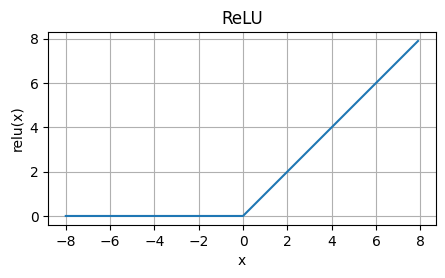

In [4]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

# 定义输入范围为-8到8之间的张量
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

# 计算ReLU函数的输出
y = torch.relu(x)

# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), y.detach(), '-')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('relu(x)')

# 添加标题
plt.title('ReLU')

# 添加网格线
plt.grid(True)

# 显示图形
plt.show()


### Grad of Relu

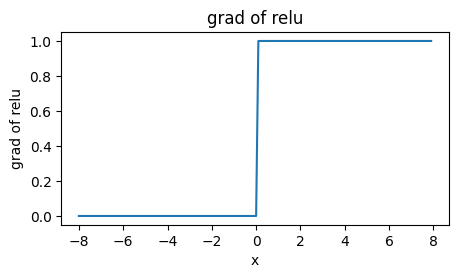

In [5]:
# 定义输入范围为-8到8之间的张量
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)

# 计算ReLU函数的输出
y = torch.relu(x)

# 对y进行反向传播，计算梯度
y.backward(torch.ones_like(x), retain_graph=True)

# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), x.grad, '-')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('grad of relu')

# 添加标题
plt.title('grad of relu')

# 显示图形
plt.show()

### Grad of Sigmod 

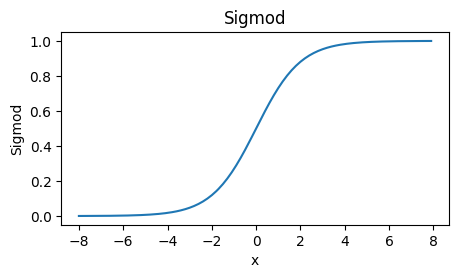

In [6]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
# 计算ReLU函数的输出

y = torch.sigmoid(x)
    
# 创建图形，并指定大小
plt.figure(figsize=(5, 2.5))

# 绘制ReLU函数的图像
plt.plot(x.detach(), y.detach(), '-')

# 添加x轴和y轴标签
plt.xlabel('x')
plt.ylabel('Sigmod')

# 添加标题
plt.title('Sigmod')

# 显示图形
plt.show()

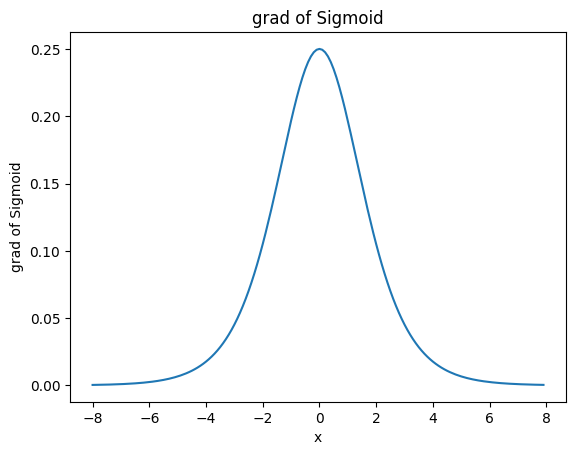

In [7]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x), retain_graph=True)
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)

plt.plot(x.detach(), x.grad.detach(), '-')  # 使用 '-' 参数指定线性样式

plt.xlabel('x')
plt.ylabel('grad of Sigmoid')
plt.title('grad of Sigmoid')
plt.show()

###  tanh

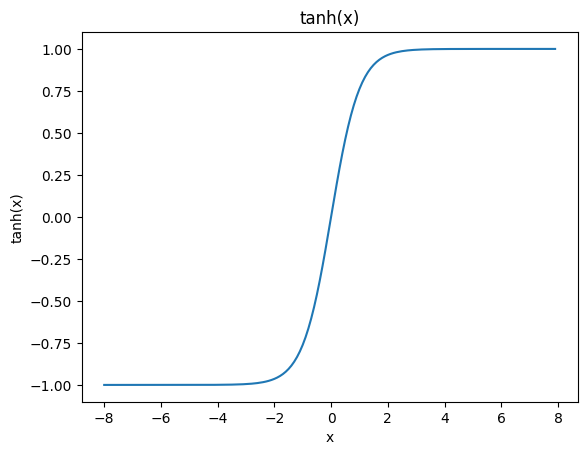

In [8]:
y = torch.tanh(x)
        
plt.plot(x.detach(), y.detach(), '-')  # 使用 '-' 参数指定线性样式

plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('tanh(x)')
plt.show()

###  Grad of tanh

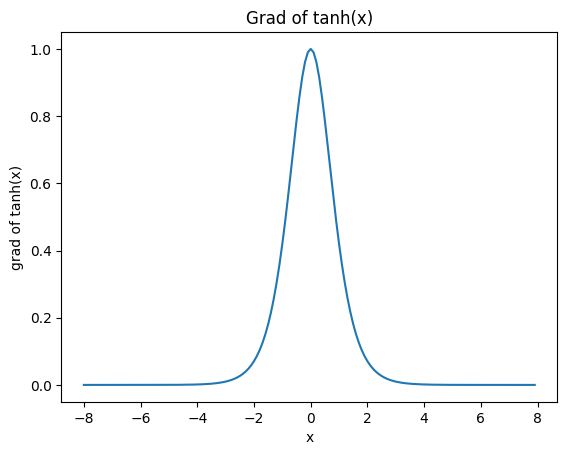

In [9]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad, '-')  # 使用 '-' 参数指定线性样式

plt.xlabel('x')
plt.ylabel('grad of tanh(x)')
plt.title('Grad of tanh(x)')
plt.show()

## MLP from zero to start

In [10]:
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### Init the model parameters

In [11]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

### Customerize Relu

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### Model

In [13]:
## reshape to transform the 2D image to a length as num_inputs
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

### Loss Function

In [14]:
loss = nn.CrossEntropyLoss(reduction='none')

### Train

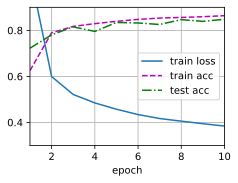

In [15]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

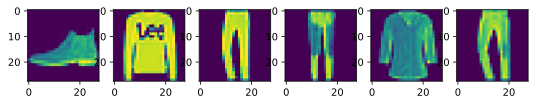

In [16]:
predict_ch3(net, test_iter)

## Easy way


In [17]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

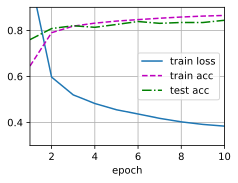

In [18]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

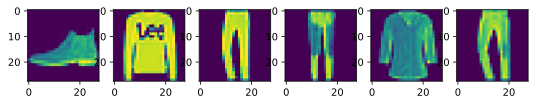

In [19]:
predict_ch3(net, test_iter)

In [20]:
for X, y in test_iter:
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    true = get_fashion_mnist_labels(y)
    print(preds[:6])
    print(true[:6])
    break

['ankle boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser']
['ankle boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser']


## Model Selection, Underfitting, Overfitting

### Dataset

In [21]:
import math
import numpy as np

max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])


features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features) # randomly change the order of features
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) #特徵數據進行多項式擴展，計算特徵的不同次方
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)! Normalization
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) ## 添加噪音 add noise to simulate the real world

In [22]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.1922],
         [1.9411]]),
 tensor([[1.0000e+00, 1.1922e+00, 7.1067e-01, 2.8242e-01, 8.4174e-02, 2.0070e-02,
          3.9880e-03, 6.7921e-04, 1.0122e-04, 1.3408e-05, 1.5985e-06, 1.7325e-07,
          1.7212e-08, 1.5785e-09, 1.3442e-10, 1.0684e-11, 7.9606e-13, 5.5827e-14,
          3.6976e-15, 2.3201e-16],
         [1.0000e+00, 1.9411e+00, 1.8838e+00, 1.2189e+00, 5.9148e-01, 2.2962e-01,
          7.4283e-02, 2.0598e-02, 4.9978e-03, 1.0779e-03, 2.0922e-04, 3.6919e-05,
          5.9718e-06, 8.9166e-07, 1.2363e-07, 1.5998e-08, 1.9408e-09, 2.2160e-10,
          2.3896e-11, 2.4412e-12]]),
 tensor([5.6306, 7.6484]))

### Train and Test

In [23]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [24]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### Good Sample

weight: [[ 5.005181   1.206974  -3.3932128  5.56568  ]]


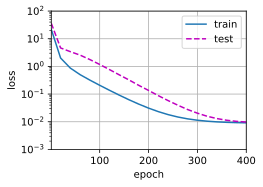

In [25]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

### Underfitting

weight: [[3.7474606 2.933313 ]]


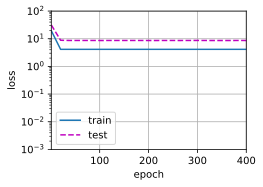

In [26]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

### Overfitting

weight: [[ 4.98781     1.2389977  -3.2765148   5.2271132  -0.37216952  1.4239712
  -0.12606928  0.362683   -0.16020189  0.10753861 -0.13445295 -0.22186358
  -0.08036046  0.19392619  0.21008551 -0.11845911 -0.21625149  0.10075668
   0.05829549  0.15102276]]


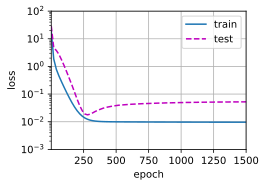

In [27]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

## weight decay

### High-dimensional regression

In [28]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

### Init Models

In [29]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### Define L2 penality  

In [30]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### Define Train Code  

In [31]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: linreg(X, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 14.009973526000977


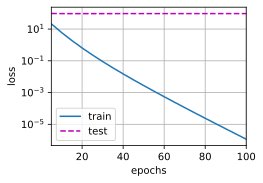

In [32]:
train(lambd=0) 
# serious overfit

w的L2范数是： 0.37044399976730347


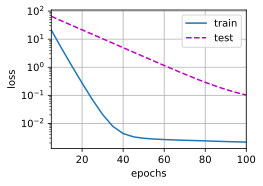

In [33]:
train(lambd=3)

w的L2范数是： 0.023666920140385628


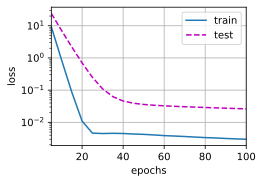

In [34]:
train(lambd=10)

### Easy Weight decay

In [35]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (evaluate_loss(net, train_iter, loss),
                          evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.691001892089844


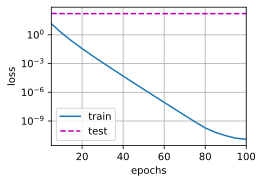

In [36]:
train_concise(0) # it is faster

w的L2范数： 0.38067948818206787


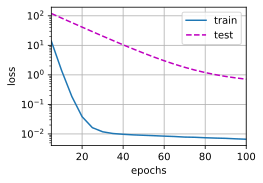

In [37]:
train_concise(3)

## Dropout

In [38]:
import torch
from torch import nn

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [39]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  6.,  0.,  0.,  0., 14.],
        [ 0.,  0., 20., 22., 24., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Define Models

In [40]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### Train and Test 

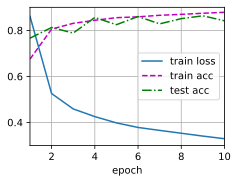

In [41]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### Easy Model 

In [42]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

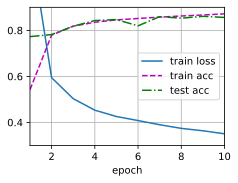

In [43]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Forward Propagation, Backward Propagation, and Computational Graphs

In [44]:
# Forward Propagation
# 创建输入数据
x = torch.tensor([2.0])

# 定义神经网络的参数
w1 = torch.tensor([[1.0]])
b1 = torch.tensor([1.0])
w2 = torch.tensor([[2.0]])
b2 = torch.tensor([2.0])

# 前向传播
h1 = torch.matmul(x, w1) + b1  # 计算第一个隐藏层的输出
a1 = torch.relu(h1)            # 对第一个隐藏层的输出应用 ReLU 激活函数
h2 = torch.matmul(a1, w2) + b2 # 计算输出层的输出

# 输出结果
print("h1:", h1)
print("a1:", a1)
print("h2:", h2)
print(h2.item())  # 打印输出层的输出值

h1: tensor([3.])
a1: tensor([3.])
h2: tensor([8.])
8.0


In [45]:
# Backward Propagation
x = torch.tensor([2.0], requires_grad=True)

# 定义计算图
y = x ** 2  # y = x^2
z = y * 3   # z = 3y

# 计算 z 相对于 x 的梯度
z.backward()

# 打印 x 的梯度
print(x.grad)


tensor([12.])


## Vanishing and Exploding Gradients

<Axes: >

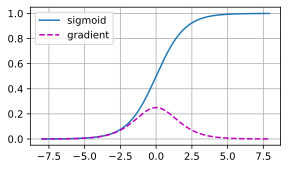

In [46]:
# Vanishing
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [47]:
# Exploding Gradients
M = torch.normal(0, 1, size=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('乘以100个矩阵后\n', M)

一个矩阵 
 tensor([[ 0.4976, -0.7288,  1.1546,  1.0085],
        [ 1.4936,  0.6507, -1.1390,  0.1412],
        [ 0.1974, -0.6852,  0.3445,  0.9342],
        [-0.8526, -0.4336,  2.0070,  1.2047]])
乘以100个矩阵后
 tensor([[-6.9440e+25, -7.9786e+25, -2.1638e+25,  1.0633e+26],
        [-4.9206e+26, -5.6538e+26, -1.5333e+26,  7.5349e+26],
        [-5.3643e+26, -6.1635e+26, -1.6716e+26,  8.2142e+26],
        [ 6.7593e+26,  7.7663e+26,  2.1063e+26, -1.0350e+27]])


In [48]:
# Exploding Gradients
M = torch.normal(0, 1, size=(4,4))
print('一个矩阵 \n',M)
for i in range(5):
    M = torch.mm(M,M)
print('乘以256个矩阵后\n', M)

一个矩阵 
 tensor([[ 3.0812e-01, -1.1152e+00, -1.0848e-01, -1.5123e-01],
        [ 2.0103e-01,  4.1746e-01,  1.1367e+00, -1.3842e-03],
        [-1.3877e-01, -4.6301e-01,  1.1152e+00, -7.8261e-01],
        [-1.4382e-01,  1.1895e+00,  1.9675e+00, -3.0622e+00]])
乘以256个矩阵后
 tensor([[ 2.5343e+11, -1.8494e+12, -1.7387e+12,  4.5145e+12],
        [-5.9070e+11,  4.3105e+12,  4.0524e+12, -1.0522e+13],
        [ 1.6211e+12, -1.1829e+13, -1.1121e+13,  2.8877e+13],
        [ 8.3495e+12, -6.0928e+13, -5.7281e+13,  1.4873e+14]])


## Predicting House Prices on Kaggle

In [49]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [50]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [51]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [52]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [53]:
import pandas as pd
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [54]:
print(train_data)
print(train_data.shape)
print(test_data.shape)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

In [55]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [60]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


### Data Preprocessing 

In [66]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.202033,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.525112,0.580807,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
1,-0.873466,0.501785,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.572152,1.177910,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
2,0.067320,-0.061269,0.137173,0.646073,-0.507197,0.980053,0.848819,0.334770,0.097856,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
3,0.302516,-0.436639,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.572152,-0.494856,-0.29308,...,-0.049021,0.394951,-0.018509,3.789226,-0.064238,-0.091035,-0.126513,-2.155097,-0.302641,0.0
4,0.067320,0.689469,0.518814,1.355319,-0.507197,0.947040,0.753100,1.387248,0.468851,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.266564,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.572152,-0.969026,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0
1455,2.419286,-2.266564,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.572152,-0.415828,-0.29308,...,-0.049021,0.394951,-0.018509,3.789226,-0.064238,-0.091035,-0.126513,-2.155097,-0.302641,0.0
1456,-0.873466,4.255477,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.572152,1.717937,-0.29308,...,-0.049021,0.394951,-0.018509,3.789226,-0.064238,-0.091035,-0.126513,-2.155097,-0.302641,0.0
1457,0.655311,-0.342796,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.572152,-0.229233,-0.29308,...,-0.049021,0.394951,-0.018509,-0.263816,-0.064238,-0.091035,-0.126513,0.463857,-0.302641,0.0


In [72]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

### Train

In [77]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
train_features

tensor([[ 0.0673, -0.2020, -0.2178,  ...,  0.4639, -0.3026,  0.0000],
        [-0.8735,  0.5018, -0.0720,  ...,  0.4639, -0.3026,  0.0000],
        [ 0.0673, -0.0613,  0.1372,  ...,  0.4639, -0.3026,  0.0000],
        ...,
        [ 0.3025, -0.1551, -0.1428,  ...,  0.4639, -0.3026,  0.0000],
        [-0.8735, -0.0613, -0.0572,  ...,  0.4639, -0.3026,  0.0000],
        [-0.8735,  0.2672, -0.0293,  ...,  0.4639, -0.3026,  0.0000]])

    In this place, we use a linear to detact the baseline, so we can know our best model which is 
    better than our simple model.

In [78]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [79]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [80]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K-fold vaildation

In [81]:
##
def get_k_fold_data(k, i, X, y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid